In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.datasets import fetch_openml

# Предсказать превышает ли доход конкретного человека 50.000$ в год, основываясь на данных переписи населения в США
https://archive.ics.uci.edu/ml/datasets/Adult
### Скачанные данные уже разбиты на тренировочную и тестовую выборки, но в качестве тренировки объединим их и затем вручную разделим на тренировочную и тестовую

In [2]:
data = pd.read_csv('adult.data')
test = pd.read_csv('adult.test')

In [3]:
# объединяем выборки
X = pd.concat([data, test], sort=False, axis=0, ignore_index=True)

In [4]:
X.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.
48841,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K.


In [5]:
# как можно заметить, последний столбец отражает какому классу принадлежит человек.
# Сделаем отдельный вектор столбцов и приведем его к виду 0 - <=50K, 1 - >50K

X['class'] = X['class'].apply(lambda x: '>50K' in x)
y = X['class'].copy()
# X.drop('class', axis=1, inplace=True)

In [6]:
# избавляюсь от пробелов в каждой ячейке таблицы
X = X.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
# Датасет содержит в себе категориальные и числовые признаки
# Признаки и их значения:
for i in X.columns:
    if X[i].dtype == "object":
        print(i, ':', X[i].unique())
    else:
        print(i, ': number')

age : number
workclass : ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
fnlwgt : number
education : ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
education-num : number
marital-status : ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation : ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
relationship : ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
race : ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex : ['Male' 'Female']
capital-gain : number
capital-loss : number
hours-per-wee

In [7]:
# проверим наличие пустых ячеек
X.isnull().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
class             False
dtype: bool

In [8]:
# как можно заметить, в категориальных столбцах присутствует значение '?', будем считать его пропущенным
# узнаем как часто он встречается в каждом из столбцов
for i in X.columns:
    if X[i].dtype =="object":
        if '?' in X[i].value_counts():
            print(i)
            print(X[i].value_counts()['?'] / X[i].value_counts().sum() * 100)

workclass
5.7307235575938735
occupation
5.751197739650301
native-country
1.7546374022357807


### Пропущенные значения присутствуют в трех столбцах: Рабочий класс (5.73%), род занятий(5.75%) и страна рождения(1.75%)
### Пропущенные значения в столбцах, соответствующих категориальным признакам, заполним модой:


In [9]:
X.loc[X['workclass'] == '?', 'workclass'] = X['workclass'].mode().iloc[0]
X.loc[X['occupation'] == '?', 'occupation'] = X['occupation'].mode().iloc[0]
X.loc[X['native-country'] == '?', 'native-country'] = X['native-country'].mode().iloc[0]

In [10]:
X.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,False
48838,64,Private,321403,HS-grad,9,Widowed,Prof-specialty,Other-relative,Black,Male,0,0,40,United-States,False
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,False
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,False
48841,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,True


### Признак fnlwgt означает кол-во людей с такими же характеристиками, как описываемый человек
#### Рассмотрим некоторые зависимости данного признака

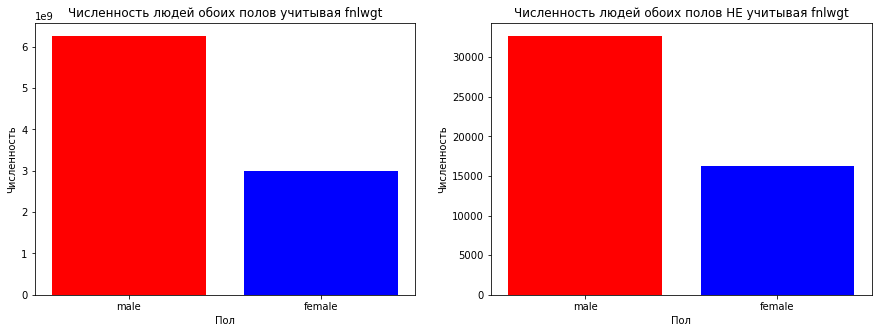

In [11]:
f, axs = plt.subplots(1,2,figsize=(15,5))

male_count = X[X['sex'] == 'Male']['fnlwgt'].sum()
female_count = X[X['sex'] == 'Female']['fnlwgt'].sum()


axs[0].bar(x=['male', 'female'], height=[male_count, female_count], color=['red', 'blue'])
axs[0].set_title('Численность людей обоих полов учитывая fnlwgt')
axs[0].set_xlabel('Пол')
axs[0].set_ylabel('Численность')

male_count = len(X[X['sex'] == 'Male'])
female_count = len(X[X['sex'] == 'Female'])


axs[1].bar(x=['male', 'female'], height=[male_count, female_count], color=['red', 'blue'])
axs[1].set_title('Численность людей обоих полов НЕ учитывая fnlwgt')
axs[1].set_xlabel('Пол')
axs[1].set_ylabel('Численность')

plt.show()

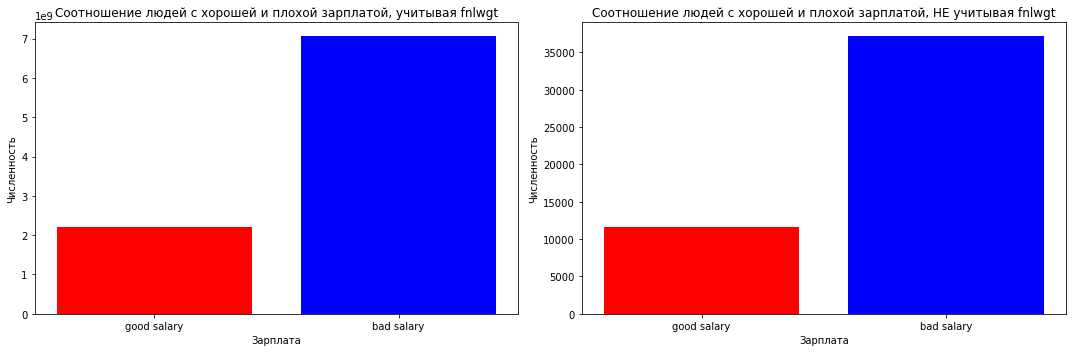

In [12]:
f, axs = plt.subplots(1,2,figsize=(15,5))

gs_people = X[X['class'] == True]['fnlwgt'].sum()
not_gs_people = X[X['class'] == False]['fnlwgt'].sum()


axs[0].bar(x=['good salary', 'bad salary'], height=[gs_people, not_gs_people], color=['red', 'blue'])
axs[0].set_title('Соотношение людей с хорошей и плохой зарплатой, учитывая fnlwgt')
axs[0].set_xlabel('Зарплата')
axs[0].set_ylabel('Численность')

gs_people = len(X[X['class'] == True])
not_gs_people = len(X[X['class'] == False])

axs[1].bar(x=['good salary', 'bad salary'], height=[gs_people, not_gs_people], color=['red', 'blue'])
axs[1].set_title('Соотношение людей с хорошей и плохой зарплатой, НЕ учитывая fnlwgt')
axs[1].set_xlabel('Зарплата')
axs[1].set_ylabel('Численность')

plt.tight_layout()

In [13]:
# так как распределения особо не изменяются, то есть признак fnlwgt не влияет на данные.
# значит он бесполезен и мы можем от него избавиться
X.drop('fnlwgt', inplace=True, axis=1)
X.tail()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
48837,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,False
48838,64,Private,HS-grad,9,Widowed,Prof-specialty,Other-relative,Black,Male,0,0,40,United-States,False
48839,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,False
48840,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,False
48841,35,Self-emp-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,True


### Рассмотрим графики зависимости между каждой парой признаков

No handles with labels found to put in legend.


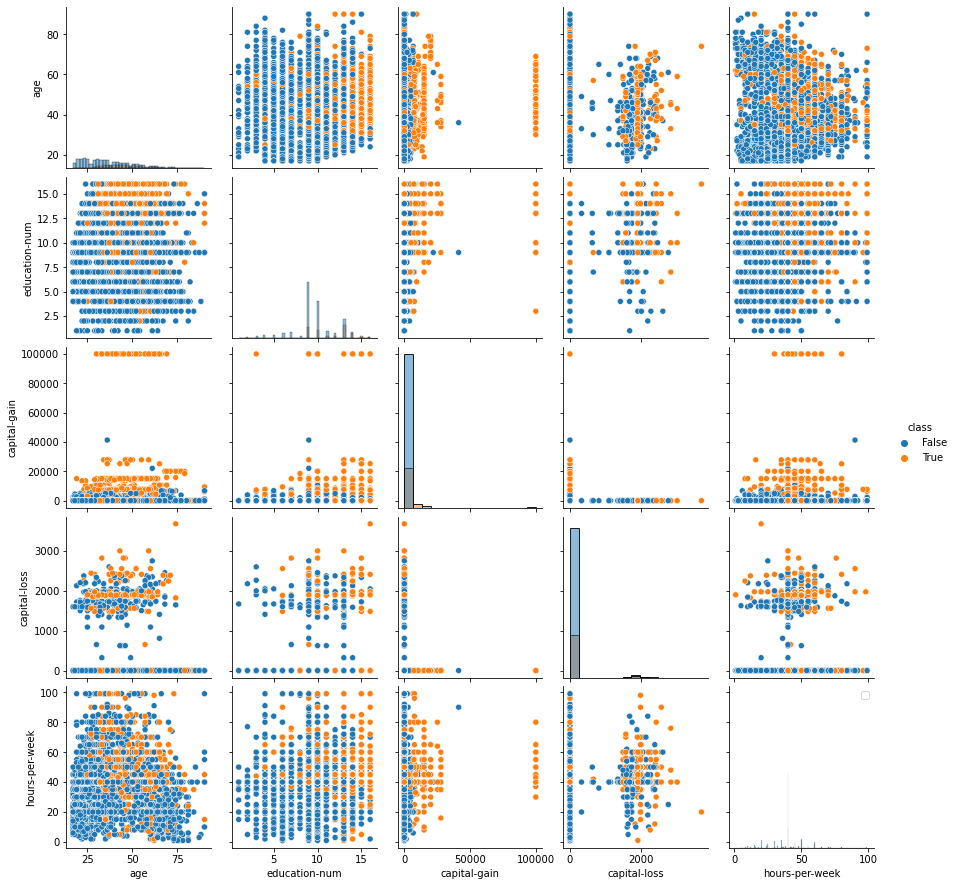

In [14]:
np.random.seed(142)
random_subset = np.random.choice(np.arange(X.shape[0]), size=10000, replace=False)
sns.pairplot(X.iloc[random_subset], hue='class', diag_kind='hist')
plt.legend()

## Корреляция

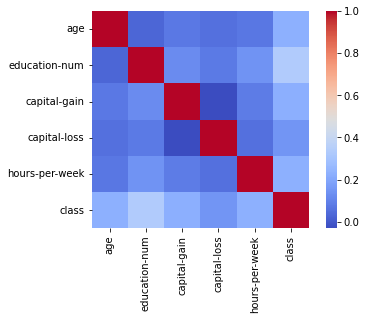

In [15]:
sns.heatmap(X.corr(), square=True, cmap='coolwarm')
pass

#### как можно заметить, коррелирующих признаков нет

## Для обработки категориальных признаков воспользуемся методом onehot encoding. Он заключается в создании отдельного столбца для каждого признака и отмечается True в том столбце, к которому относится человек, в других ставим False
### Воспользуемся функцией get_dummies

In [16]:
to_delete = []
for column in X.columns:
    if X[column].dtype != "object":
        continue
    to_delete.append(column)
print(to_delete)

for i in to_delete:
    X_process = pd.get_dummies(X[i])
    X = pd.concat((X, X_process), axis=1)
    X = X.drop(i, axis=1)
X.drop('class', inplace=True, axis=1)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [17]:
X.tail()

,age,education-num,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
48837,39,13,0,0,36,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
48838,64,9,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
48839,38,13,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
48840,44,13,5455,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
48841,35,13,0,0,60,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## Распределение классов в датасете

In [18]:
y.value_counts() / y.value_counts().sum()

False    0.760718
True     0.239282
Name: class, dtype: float64

## Нормализация только численных признаков


In [19]:
from sklearn.preprocessing import MinMaxScaler

col = []
for column in X.columns:
    if X[column].dtype not in ["object", "bool"]:
        col.append(column)
X[col] = MinMaxScaler().fit_transform(X[col].values)
X.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,...,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,0.296487,0.605206,0.010791,0.020088,0.402269,0.029319,0.064207,0.000205,0.751505,0.034704,...,0.001372,0.003767,0.000430,0.002355,0.001331,0.000614,0.000553,0.914971,0.001761,0.000471
std,0.187815,0.171398,0.074521,0.092517,0.126443,0.168701,0.245124,0.014307,0.432145,0.183030,...,0.037012,0.061263,0.020731,0.048467,0.036457,0.024776,0.023506,0.278928,0.041925,0.021695
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.397959,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.273973,0.600000,0.000000,0.000000,0.397959,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.424658,0.733333,0.000000,0.000000,0.448980,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Деление выборки на обучающую и тестовую

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## kNN

In [21]:
# получим результаты точностей и потерь для некоторого количества соседей на тренировочной и тестовой выборках
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss

accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
neighbors = []

def calc(X_train, X_test, y_train, y_test, k):
    model = KNeighborsClassifier(algorithm='brute', n_neighbors=k, n_jobs=-1)
    model.fit(X_train, y_train)
    neighbors.append(k)
    accuracy_train.append(accuracy_score(y_train, model.predict(X_train)))
    accuracy_test.append(accuracy_score(y_test, model.predict(X_test)))
    loss_train.append(log_loss(y_train, model.predict_proba(X_train)))
    loss_test.append(log_loss(y_test, model.predict_proba(X_test)))
    
for k in range(5, 51, 5):
    calc(X_train, X_test, y_train, y_test, k)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
C:\Users\User\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\User

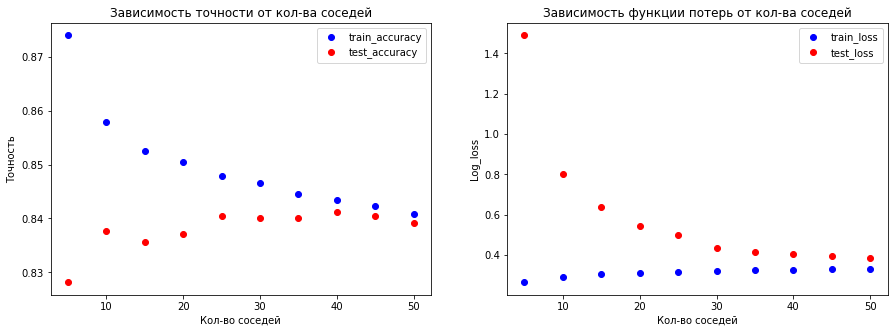

In [22]:
# сделаем графики
f, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(neighbors, accuracy_train, 'bo', neighbors, accuracy_test, 'ro')
axs[0].legend(['train_accuracy', 'test_accuracy'])
axs[0].set_title('Зависимость точности от кол-ва соседей')
axs[0].set_xlabel('Кол-во соседей')
axs[0].set_ylabel('Точность')

axs[1].plot(neighbors, loss_train, 'bo', neighbors, loss_test, 'ro')
axs[1].legend(['train_loss', 'test_loss'])
axs[1].set_title('Зависимость функции потерь от кол-ва соседей')
axs[1].set_xlabel('Кол-во соседей')
axs[1].set_ylabel('Log_loss')


plt.show()

### Как можно заметить, при 40 соседях точность на тестовой выборке достигает максимума. При больших количествах точность на обоих выборках начинает убывать практически параллельно. По функции потерь картина немного другая, здесь мы видим как обе выборки приближаются к значению 0.4. Возможно, использование других классификаторов поможет улучшить точность.